In [1]:
from typing import List, Dict, Tuple, Callable
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [2]:
from sklearn.datasets import fetch_openml

adult_income = fetch_openml(name="adult", version=2)
X = adult_income.data
y = adult_income.target
df = pd.concat([X, y], axis=1)
target_column = df.columns[-1]
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


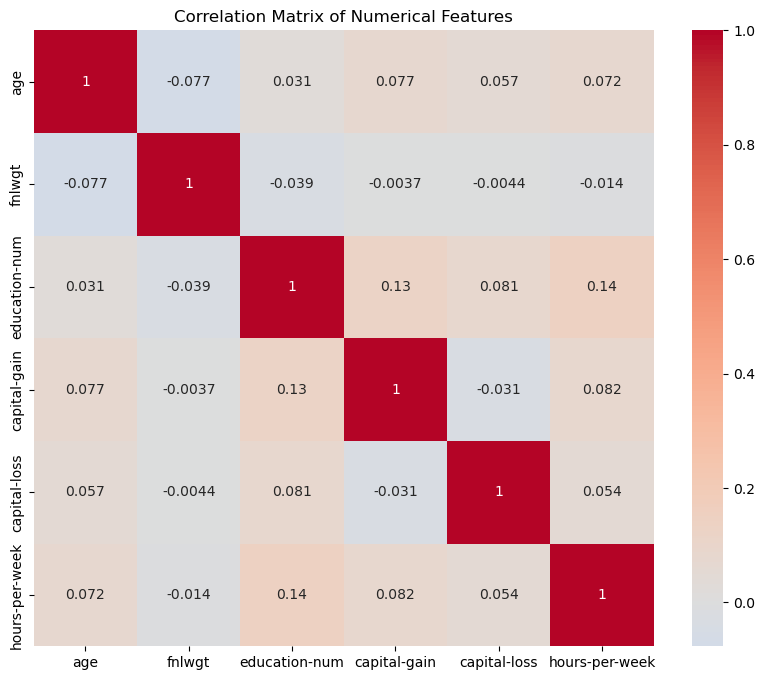

In [3]:
# Correlation matrix for numerical features
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

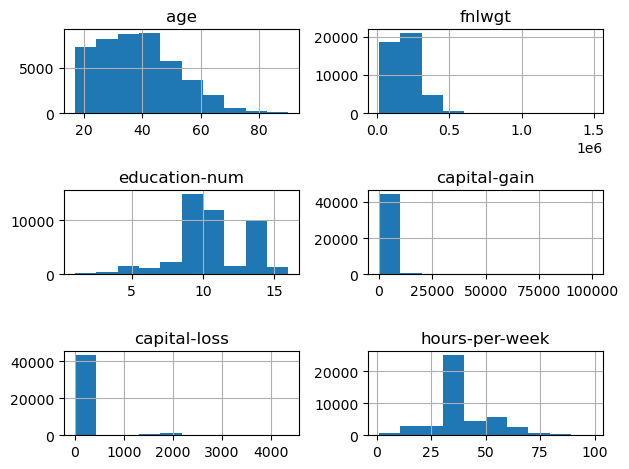

In [168]:
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
subset = df[num_ix]

df = df.dropna()
# select columns with numerical data types
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
# select a subset of the dataframe with the chosen columns
subset = df[num_ix]
# create a histogram plot of each numeric variable
subset.hist()
plt.tight_layout()
plt.show()

In [4]:
def clean_data(df):
    df = df.copy()
    df = df.replace('?', np.nan)
    
    # Fill missing values
    # For categorical columns, fill with mode
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

In [5]:
def get_preprocessed_data(X_trn, X_tst) -> Tuple[np.ndarray]:  
    '''
    1. Separate numerical and categorical columns
    2. Standardize numerical features
    3. One-hot encode categorical features
    4. Combine processed features
    '''
    # Separate column types
    numerical_features = X_trn.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_trn.select_dtypes(include=['object']).columns

    scaler = StandardScaler()
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    # Process numerical features
    X_trn_num = X_trn[numerical_features].copy()
    X_tst_num = X_tst[numerical_features].copy()
    X_trn_num_scaled = scaler.fit_transform(X_trn_num)
    X_tst_num_scaled = scaler.transform(X_tst_num)
    X_trn_num_scaled = pd.DataFrame(X_trn_num_scaled, columns=numerical_features)
    X_tst_num_scaled = pd.DataFrame(X_tst_num_scaled, columns=numerical_features)

    # Process categorical features
    X_trn_cat = X_trn[categorical_features].copy()
    X_tst_cat = X_tst[categorical_features].copy()
    X_trn_cat_encoded = encoder.fit_transform(X_trn_cat)
    X_tst_cat_encoded = encoder.transform(X_tst_cat)

    # Get feature names for encoded categorical variables
    encoded_feature_names = []
    for i, feature in enumerate(categorical_features):
        unique_vals = X_trn[feature].unique()
        # Skip the first value due to drop='first'
        encoded_feature_names.extend([f"{feature}_{val}" for val in unique_vals[1:]])
    
    X_trn_cat_encoded = pd.DataFrame(X_trn_cat_encoded, columns=encoded_feature_names)
    X_tst_cat_encoded = pd.DataFrame(X_tst_cat_encoded, columns=encoded_feature_names)

    # Combine numerical and categorical features
    X_trn_processed = pd.concat([X_trn_num_scaled, X_trn_cat_encoded], axis=1)
    X_tst_processed = pd.concat([X_tst_num_scaled, X_tst_cat_encoded], axis=1)

    return X_trn_processed, X_tst_processed, list(X_trn_processed.columns)

In [6]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return np.exp(z)/(1+np.exp(z))

In [7]:
def log_loss(y: np.ndarray, probs: np.ndarray) -> float:
    m = len(y)
    return -1/m * np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))

In [8]:
class LogisticRegression:
    def __init__(self, learning_rate: float = 0.01, iterations: int = 1000, lambda_reg: float = 0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda_reg = lambda_reg
        self.weights = None
        self.bias = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        
        for i in range(self.iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = sigmoid(z)
            
            # Compute the gradients
            dw = (1/m) * np.dot(X.T, (y_pred - y)) + (self.lambda_reg * self.weights)
            db = (1/m) * np.sum(y_pred - y)         
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            '''
            # Print the loss every 100 iterations
            if i % 100 == 0:
                current_loss = log_loss(y, y_pred)
                print(f"Iteration {_}, Loss: {current_loss:.4f}")
            '''
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Return 1 if prob >= 0.5 else 0
        z = np.dot(X, self.weights) + self.bias
        y_pred_prob = sigmoid(z)
        return (y_pred_prob >= 0.5).astype(int)

In [9]:
#Clean data
df_cleaned = clean_data(df)

#Prepare target variable
le = LabelEncoder()
y = le.fit_transform(df_cleaned[target_column])
X = df_cleaned.drop(target_column, axis=1)

#Split the data
from sklearn.model_selection import train_test_split
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=0.8, random_state=42)

#Preprocess the features
X_trn_processed, X_tst_processed, feature_names = get_preprocessed_data(X_trn, X_tst)

In [10]:
# Train the Logistic Regression
def train_logistic_regression(X_trn, X_tst, y_trn, y_tst):
    logreg = LogisticRegression(learning_rate = 0.01, iterations = 2000, lambda_reg=0.01)
    logreg.fit(X_trn, y_trn)

    y_pred = logreg.predict(X_tst)

    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

    print(f"Accuracy: {accuracy_score(y_tst, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_tst, y_pred))

    conf_matrix = confusion_matrix(y_tst, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return logreg

Accuracy: 0.8078

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      7479
           1       0.69      0.32      0.44      2290

    accuracy                           0.81      9769
   macro avg       0.76      0.64      0.66      9769
weighted avg       0.79      0.81      0.78      9769



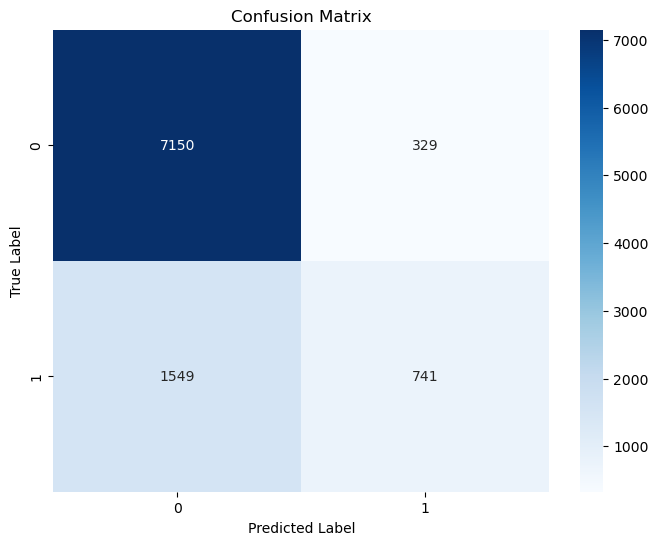

In [11]:
logRegModel = train_logistic_regression(X_trn_processed, X_tst_processed, y_trn, y_tst)

In [12]:
class RidgeRegressionLMS:
    def __init__(self, learning_rate=0.01, iterations=1000, lambda_reg=1.0):
        self.learning_rate = learning_rate  
        self.iterations = iterations  
        self.lambda_reg = lambda_reg

    def fit(self, X: np.ndarray, y: np.ndarray):
        m, n = X.shape
        self.theta = np.zeros(n)
        
        # Gradient descent loop
        for i in range(self.iterations):
            predictions = X.dot(self.theta)
            errors = predictions - y
            
            gradient = (1/m) * X.T.dot(errors) + (self.lambda_reg / m) * self.theta
            self.theta -= self.learning_rate * gradient

    def predict(self, X: np.ndarray):
        return X.dot(self.theta)

In [13]:
def train_ridge_regression(X_trn, X_tst, y_trn, y_tst):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
    ridgeRegression = RidgeRegressionLMS(learning_rate=0.01, iterations=1000, lambda_reg=1.0)

    # Train the model
    ridgeRegression.fit(X_trn, y_trn)

    y_pred = ridgeRegression.predict(X_tst)
    #Threshold for classification between 1 or 0 on continuous output
    y_pred_binary = (y_pred >= 0.5).astype(int)

    # Compute classification metrics
    accuracy = accuracy_score(y_tst, y_pred_binary)
    precision = precision_score(y_tst, y_pred_binary)
    recall = recall_score(y_tst, y_pred_binary)
    conf_matrix = confusion_matrix(y_tst, y_pred_binary)

    # Print the results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Accuracy: 0.7770
Precision: 0.9375
Recall: 0.0524


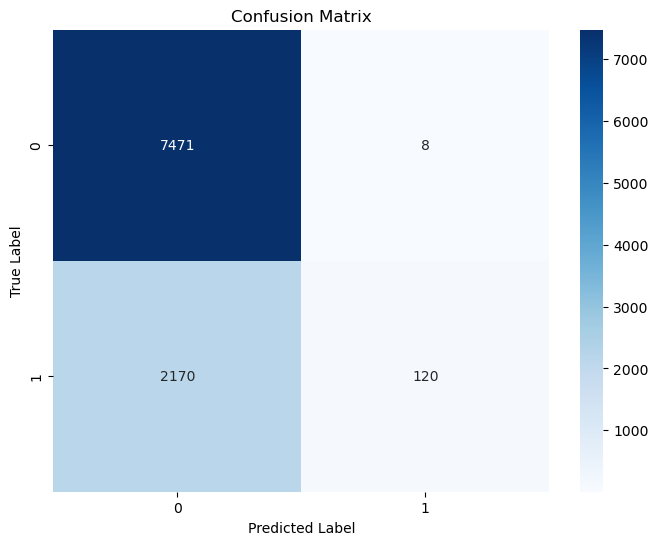

In [14]:
ridgeModel = train_ridge_regression(X_trn_processed, X_tst_processed, y_trn, y_tst)